# The Korteweg–de Vries Equation
$$
u_t + 6uu_x + u_{xxx} = 0
$$

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data
data = sio.loadmat('kdv.mat')

In [3]:
U = real(data['usol'])
x = data['x'][0]
t = data['t'][:,0]
n,m = U.shape #512, 201
dt = t[1]-t[0]
dx = x[1]-x[0]

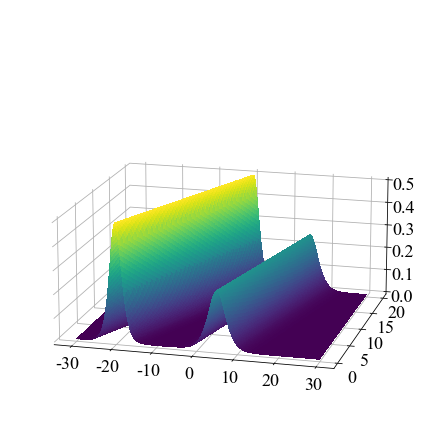

In [4]:
X, T = np.meshgrid(x, t)
figure = plt.figure()
from matplotlib.pyplot import MultipleLocator
figure.set_figheight(6)
figure.set_figwidth(6)
ax = Axes3D(figure)
plt.rcParams['axes.unicode_minus']=False
ax.view_init(15, -75)
x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(5)
z_major_locator=MultipleLocator(0.1)

ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.zaxis.set_major_locator(z_major_locator)
ax.tick_params(axis='x',labelsize=18,width=24)
ax.tick_params(axis='y',labelsize=18,width=24)
ax.tick_params(axis='z',labelsize=18,width=24)
labels = ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()
[label.set_fontname('Times New Roman') for label in labels]
ax.plot_surface(X,T,U.T,rstride=1,cstride=1, cmap=cm.viridis,linewidth=1,antialiased=False)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.9, 0.6, 1]))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.savefig("./KdV.jpg",dpi=2000) 
plt.show()

In [5]:
def build_linear_system(u, dt, dx, D = 3, P = 3,time_diff = 'poly',space_diff = 'poly',lam_t = None,lam_x = None, width_x = None,width_t = None, deg_x = 5,deg_t = None,sigma = 2):
    
    n, m = u.shape

    if width_x == None: width_x = n/10
    if width_t == None: width_t = m/10
    if deg_t == None: deg_t = deg_x

    # If we're using polynomials to take derviatives, then we toss the data around the edges.
    if time_diff == 'poly': 
        m2 = m-2*width_t
        offset_t = width_t
    else: 
        m2 = m
        offset_t = 0
    if space_diff == 'poly': 
        n2 = n-2*width_x
        offset_x = width_x
    else: 
        n2 = n
        offset_x = 0

    if lam_t == None: lam_t = 1.0/m
    if lam_x == None: lam_x = 1.0/n

    ########################
    # First take the time derivaitve for the left hand side of the equation
    ########################
    ut = np.zeros((n2,m2), dtype=np.complex64)

    if time_diff == 'FDconv':
        Usmooth = np.zeros((n,m), dtype=np.complex64)
        # Smooth across x cross-sections
        for j in range(m):
            Usmooth[:,j] = ConvSmoother(u[:,j],width_t,sigma)
        # Now take finite differences
        for i in range(n2):
            ut[i,:] = FiniteDiff(Usmooth[i + offset_x,:],dt,1)

    elif time_diff == 'poly':
        T= np.linspace(0,(m-1)*dt,m)
        for i in range(n2):
            ut[i,:] = PolyDiff(u[i+offset_x,:],T,diff=1,width=width_t,deg=deg_t)[:,0]

    elif time_diff == 'Tik':
        for i in range(n2):
            ut[i,:] = TikhonovDiff(u[i + offset_x,:], dt, lam_t)

    else:
        for i in range(n2):
            ut[i,:] = FiniteDiff(u[i + offset_x,:],dt,1)
    
    ut = np.reshape(ut, (n2*m2,1), order='F')

    ########################
    # Now form the rhs one column at a time, and record what each one is
    ########################

    u2 = u[offset_x:n-offset_x,offset_t:m-offset_t]
    Theta = np.zeros((n2*m2, (D+1)*(P+1)), dtype=np.complex64)
    ux = np.zeros((n2,m2), dtype=np.complex64)
    rhs_description = ['' for i in range((D+1)*(P+1))]

    if space_diff == 'poly': 
        Du = {}
        for i in range(m2):
            Du[i] = PolyDiff(u[:,i+offset_t],np.linspace(0,(n-1)*dx,n),diff=D,width=width_x,deg=deg_x)
    if space_diff == 'Fourier': ik = 1j*np.fft.fftfreq(n)*n
        
    for d in range(D+1):

        if d > 0:
            for i in range(m2):
                if space_diff == 'Tik': ux[:,i] = TikhonovDiff(u[:,i+offset_t], dx, lam_x, d=d)
                elif space_diff == 'FDconv':
                    Usmooth = ConvSmoother(u[:,i+offset_t],width_x,sigma)
                    ux[:,i] = FiniteDiff(Usmooth,dx,d)
                elif space_diff == 'FD': ux[:,i] = FiniteDiff(u[:,i+offset_t],dx,d)
                elif space_diff == 'poly': ux[:,i] = Du[i][:,d-1]
                elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(ux[:,i]))
        else: ux = np.ones((n2,m2), dtype=np.complex64) 
            
        for p in range(P+1):
            Theta[:, d*(P+1)+p] = np.reshape(np.multiply(ux, np.power(u2,p)), (n2*m2), order='F')

            if p == 1: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+'u'
            elif p>1: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+'u^' + str(p)
            if d > 0: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+\
                                                   'u_{' + ''.join(['x' for _ in range(d)]) + '}'

    return ut, Theta, rhs_description

In [6]:
def FiniteDiff(u, dx, d):### 
    """
    Takes dth derivative data using 2nd order finite difference method (up to d=3)
    Works but with poor accuracy for d > 3
    
    Input:
    u = data to be differentiated
    dx = Grid spacing.  Assumes uniform spacing
    """
    
    n = u.size
    ux = np.zeros(n, dtype=np.complex64)
    
    if d == 1:
        for i in range(1,n-1):
            ux[i] = (u[i+1]-u[i-1]) / (2*dx)
        
        ux[0] = (-3.0/2*u[0] + 2*u[1] - u[2]/2) / dx
        ux[n-1] = (3.0/2*u[n-1] - 2*u[n-2] + u[n-3]/2) / dx
        return ux
    
    if d == 2:
        for i in range(1,n-1):
            ux[i] = (u[i+1]-2*u[i]+u[i-1]) / dx**2
        
        ux[0] = (2*u[0] - 5*u[1] + 4*u[2] - u[3]) / dx**2
        ux[n-1] = (2*u[n-1] - 5*u[n-2] + 4*u[n-3] - u[n-4]) / dx**2
        return ux
    
    if d == 3:
        for i in range(2,n-2):
            ux[i] = (u[i+2]/2-u[i+1]+u[i-1]-u[i-2]/2) / dx**3
        
        ux[0] = (-2.5*u[0]+9*u[1]-12*u[2]+7*u[3]-1.5*u[4]) / dx**3
        ux[1] = (-2.5*u[1]+9*u[2]-12*u[3]+7*u[4]-1.5*u[5]) / dx**3
        ux[n-1] = (2.5*u[n-1]-9*u[n-2]+12*u[n-3]-7*u[n-4]+1.5*u[n-5]) / dx**3
        ux[n-2] = (2.5*u[n-2]-9*u[n-3]+12*u[n-4]-7*u[n-5]+1.5*u[n-6]) / dx**3
        return ux
    
    if d > 3:
        return FiniteDiff(FiniteDiff(u,dx,3), dx, d-3)

## Construct $\Theta (U)$ and compute $U_t$

In [7]:
Ut, R, rhs_des = build_linear_system(U, dt, dx, D=3, P=2, time_diff = 'FD', space_diff = 'FD')
['1']+rhs_des[1:]

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}']

In [8]:
import scipy.io as sio
sio.savemat('KdV_TwoSoliton.mat',{'Ut':Ut,'R':R})